<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher_New/blob/main/WorksDec_30_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visual_Transformer (ViT)を使用したモデルの構築
Visual_Transformer (ViT)を使用した手背の光学写真から関節リウマチの有無を推定するモデルを構築する。

いま、”matched_samples.csv”というcsvファイルには、"optPhotoNonRaRight"と、"optPhotoRaRight"に格納されている画像ファイルのうち、年齢と性別をマッチさせた画像ファイルだけを抽出して記録している。このcsvファイルに記録された画像ファイルは、"matched_samples”に格納されている。

さて、”matched_samples.csv”に、”RA”という1か0の２区分変数がある。画像をViTで学習して、RAが1か0かを推定するモデルを構築する。

###GoogleDriveのマウント
まず、作業環境を整える。GoogleDriveをマウントする。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### "timm"ライブラリのインストール
timmは、Ross Wightman によって作成された深層学習ライブラリである。

In [2]:
!pip install vit_pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.0 MB/s eta 0:00:00


###必要なライブラリのインポート
作業開始前に、あらかじめ必要になるライブラリをインポートしておく。

In [3]:
from __future__ import print_function
import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import timm

###各種パラメーターの設定
学習に使用するパラメーターをまとめて設定する。このようにしておくことで、学習を試行錯誤する場合に操作するコードをわかりやすくすることができる。

"lr"は学習率(learning rate: lr)を意味する。"1e-3"とは、0.01のこと。

"gamma"は更新率を意味する。デフォルト設定は0.1。この場合、更新タイミングで学習率が1/10になる。

"seed"は乱数のシードで、慣用的に42が使用されることが多い。

In [4]:
# 各種パラメーターの設定
epochs = 50
# 学習率(learning rate: lr)
lr = 1e-3
# 更新率（デフォルトは0.1）
gamma = 0.7
# 乱数のシード
seed = 42

###乱数のシードを統一する。
学習のたびに登場する乱数が変動すると、モデルの再現性がわかりにくくなってしまう。再現性を確保するために乱数のシードを統一する。

In [5]:
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
# GPUの設定
device = 'cuda'

###csvファイルの読み込み。

まず、データの記録されたcsvファイルをpandasで読み込む。そのデータから変数"filename"を読み取り、画像のパスを生成する。

In [7]:
# CSVファイルを読み込む
csv_path = '/content/drive/MyDrive/OptPhotoFiles/matched_samples.csv'
data = pd.read_csv(csv_path)

# 画像ファイルへのパスを生成
data['image_path'] = data.apply(lambda row: os.path.join('/content/drive/MyDrive/OptPhotoFiles/matched_samples', row['filename']), axis=1)

###画像読み込みクラスの定義
画像を読み込むために必要なクラス、"ImageDataset"を定義する。

In [8]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')  # RGBAをRGBに変換
        label = self.dataframe.iloc[idx]['RA']

        if self.transform:
            image = self.transform(image)

        return image, label

#画像前処置の定義
画像のサイズをViTが要求するサイズに変更し、テンソルに変換する。trainingではデータ拡張を行うが、validationとtestではデータ拡張を適応しないことに注意。

データの正規化は、ニューラルネットワークのトレーニングにおいて非常に重要である。特に、Vision Transformer (ViT) のような事前学習済みのモデルを使用する場合、モデルが事前学習された際に使われた同じ統計量（平均と標準偏差）を用いて入力データを正規化することが推奨される。

ViTモデルの多くは、ImageNetデータセットで事前学習されている。ImageNetデータセットの平均と標準偏差はそれぞれ [0.485, 0.456, 0.406] と [0.229, 0.224, 0.225] である。これらの値を使って、transformを更新する。

In [9]:
# 前処理の定義
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

###データローダーの設定
データをトレーニングセット、バリデーションセット、テストセットに分割するためには、train_test_split 関数を使うのが一般的である。これはPythonのsklearn.model_selection モジュールに含まれている。サンプル数の比率を 7:2:1 に設定するには、データを最初に 90:10 に分割し、その後、90% のデータをさらに 78:22 に分割する。これにより、全体として 7:2:1 の比率になる。このコードを使うと、データセットが所望の比率で分割され、それぞれのデータセットに対してデータローダーを作成することで、モデルのトレーニングと評価が容易になる。

In [10]:
from sklearn.model_selection import train_test_split

# 元のデータをトレーニングセットとテストセットに分割
train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# トレーニングセットをさらにトレーニングセットとバリデーションセットに分割
train_data, val_data = train_test_split(train_val_data, test_size=0.22, random_state=42)  # 0.22 ≈ 2/9

# トレーニング、バリデーション、テストセット用のデータセットとデータローダーを作成
train_dataset = ImageDataset(train_data, transform=train_transforms)
val_dataset = ImageDataset(val_data, transform=val_transforms)
test_dataset = ImageDataset(test_data, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
model_names = timm.list_models(pretrained=True)
# ファインチューニングしたい場合はpretrained=True
# model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [11]:
# ViTモデルの読み込み
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [12]:
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [16]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
train_loss_list = []
val_loss_list = []
test_loss_list = []

    #ここからが訓練用データの解析
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    #ここからが検証用データの解析
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    #ここからが学習率の更新
    scheduler.step()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.6445 - acc: 0.5601 - val_loss : 0.6467 - val_acc: 0.7188



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6157 - acc: 0.6995 - val_loss : 0.7068 - val_acc: 0.6094



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7793 - acc: 0.5481 - val_loss : 0.7066 - val_acc: 0.4453



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6770 - acc: 0.5227 - val_loss : 0.6819 - val_acc: 0.4453



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6342 - acc: 0.6248 - val_loss : 0.6716 - val_acc: 0.4688



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6206 - acc: 0.6267 - val_loss : 0.6238 - val_acc: 0.7188



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6044 - acc: 0.6886 - val_loss : 0.6524 - val_acc: 0.4609



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.5810 - acc: 0.7056 - val_loss : 0.6291 - val_acc: 0.4766



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.5925 - acc: 0.6882 - val_loss : 0.5968 - val_acc: 0.7188



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6022 - acc: 0.6466 - val_loss : 0.5911 - val_acc: 0.7422



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5821 - acc: 0.7028 - val_loss : 0.6532 - val_acc: 0.4688



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5689 - acc: 0.6986 - val_loss : 0.5905 - val_acc: 0.7734



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5623 - acc: 0.7091 - val_loss : 0.6001 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5604 - acc: 0.7185 - val_loss : 0.6091 - val_acc: 0.7422



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5580 - acc: 0.7113 - val_loss : 0.5930 - val_acc: 0.7734



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5558 - acc: 0.7115 - val_loss : 0.6021 - val_acc: 0.7500



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5539 - acc: 0.7247 - val_loss : 0.6034 - val_acc: 0.7500



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5511 - acc: 0.7212 - val_loss : 0.5980 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5498 - acc: 0.7161 - val_loss : 0.5962 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5540 - acc: 0.7128 - val_loss : 0.5950 - val_acc: 0.7656



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5533 - acc: 0.7080 - val_loss : 0.5966 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5495 - acc: 0.7177 - val_loss : 0.5970 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5528 - acc: 0.7150 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.5536 - acc: 0.7144 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.5499 - acc: 0.7155 - val_loss : 0.5968 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.5541 - acc: 0.7115 - val_loss : 0.5968 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5498 - acc: 0.7161 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5512 - acc: 0.7163 - val_loss : 0.5968 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5520 - acc: 0.7157 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5518 - acc: 0.7109 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.5513 - acc: 0.7163 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.5521 - acc: 0.7150 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5513 - acc: 0.7177 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5513 - acc: 0.7163 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.5513 - acc: 0.7177 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5506 - acc: 0.7148 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5526 - acc: 0.7163 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.5515 - acc: 0.7122 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5487 - acc: 0.7177 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5494 - acc: 0.7177 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5474 - acc: 0.7196 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5498 - acc: 0.7148 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.5522 - acc: 0.7157 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5513 - acc: 0.7115 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5488 - acc: 0.7177 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5500 - acc: 0.7183 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5500 - acc: 0.7163 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5492 - acc: 0.7196 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5501 - acc: 0.7157 - val_loss : 0.5969 - val_acc: 0.7578



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5500 - acc: 0.7170 - val_loss : 0.5969 - val_acc: 0.7578



### テストデータを用いた最終的な性能評価

In [17]:
# 現在のトレーニングループと検証ループの後に追加

# テストデータに対する性能評価
with torch.no_grad():  # 勾配の計算を無効化
    epoch_test_accuracy = 0
    epoch_test_loss = 0
    for data, label in test_loader:  # テストデータローダーからバッチを取得
        data = data.to(device)
        label = label.to(device)

        test_output = model(data)
        test_loss = criterion(test_output, label)

        acc = (test_output.argmax(dim=1) == label).float().mean()
        epoch_test_accuracy += acc / len(test_loader)
        epoch_test_loss += test_loss / len(test_loader)

    print(
        f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}"
    )

    test_acc_list.append(epoch_test_accuracy)
    test_loss_list.append(epoch_test_loss)

Test Loss: 0.6766, Test Accuracy: 0.5938


### 学習プロセスの可視化

<ipython-input-18-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


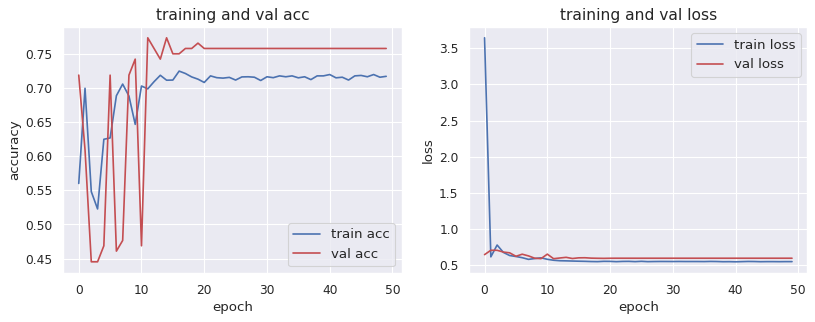

In [18]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

### 学習を終えたモデルのcheckpointの保存

学習したモデルのcheckpointを保存するには、"model_save_path"を指定する。

In [21]:
model_save_path = '/content/drive/MyDrive/OptPhotoFiles/model.pth'
torch.save(model.state_dict(), model_save_path)

# Grad-Camを使用して、モデルの判断過程を可視化する。
Grad-Camを使用して、Vision Transformerのモデルがどのように画像を理解し、特定のクラスに対する予測を行っているかを、直感的に解釈できるように可視化する。これは、モデルの解釈可能性を高め、特に医療画像分析のような重要な応用分野において非常に有用な技術である。

Vision Transformerのモデルは、画像を一連のパッチに分割し、それらを1次元のシーケンスとして処理します。このシーケンスは通常、画像の空間的な配置情報を直接的に保持していない。そこで、reshape_transform 関数を用いて1次元のシーケンス形式のアクティベーションマップを2次元の画像グリッドに変換する。これによって、これらのシーケンスを元の画像の空間的な配置に対応する形状に再構成することができる。その結果、各パッチが元の画像のどの部分に対応しているかを可視化できるようになり、CNNで使用されるGrad-CAMのような手法を応用することが可能になる。

まず、Grad-Camをインストールする。

In [13]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=a3e3e788866230f6b0416ed3c8d694a07fe8fef45a161f30b80465b6371d1424
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


必要なライブラリをインポートする。

In [14]:
import argparse
import cv2
import numpy as np
import torch

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

###コマンドライン引数を解析する"get_args"関数の定義
get_args 関数は、スクリプトの実行時に指定されるコマンドライン引数を解析する。これには、GPUの使用、入力画像のパス、CAMメソッドの選択などのオプションが含まれる。この関数は引数を取らず、呼び出されるとコマンドライン引数に基づいて設定を返す。

get_args 関数は、スクリプトの実行時に様々な実験条件や設定を柔軟に指定するために使用される。この関数を使用することで、スクリプトはコマンドラインから異なるパラメータを受け取り、それに応じて異なる動作をするように設計することができる。例えば、異なる入力画像、異なるCAMメソッド、GPUの使用や不使用、データ拡張の適用などの条件を、スクリプト実行時に指定できるようになる。

このアプローチにより、同じコードを異なる条件で複数回実行する際にも、都度コードを変更する必要がなくなり、実験や解析の効率が大幅に向上する。また、このような設計は、実験の再現性を高め、他の研究者がこの実験を容易に再現できるようにするのにも役立つ。

作業環境がJupyter notebook、あるいはGoogle Colaboratoryでなければ、以下のコードを使用する。

In [15]:
#関数"get_args"を宣言。
def get_args():
    # "argparse.AugumentParser"は、コマンドライン引数を解析するオブジェクトを作成。
    parser = argparse.ArgumentParser()
    # "--use-cuda"オプションが指定されると、スクリプトはNVIDIA GPUを使用する
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    # "--image-path"オプションは入力画像のパスを指定する。デフォルト値は './examples/both.png'
    parser.add_argument(
        '--image-path',
        type=str,
        default='./examples/both.png',
        help='Input image path')
    # "--aug_smooth"オプションは、マップの平滑化にテスト時データ拡張を適用するかどうかを制御する
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    # "--eigen_smooth"オプションは、CAMの重みと活性化に対して主成分分析を適用してノイズを減らすかどうかを制御する
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')
    # "--method"オプションは、使用するCAMメソッドを指定する
    parser.add_argument(
        '--method',
        type=str,
        default='gradcam',
        help='Can be gradcam/gradcam++/scorecam/xgradcam/ablationcam')
    # parser.parse_args() は指定された全てのオプション("--use-cuda"など)が含まれるコマンドライン引数を解析する
    args = parser.parse_args()
    # ユーザーが"--use-cuda"を指定し、CUDAが利用可能である場合だけ、"args.use_cuda"を"True"に設定する。
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')
    # 解析された引数を含む"args"オブジェクトを返す。このオブジェクトは、スクリプトの他の部分で実験条件として参照される。
    return args

ただし、Jupyterノートブック（またはGoogle Colab）の環境でargparseを使用してコマンドライン引数を解析する場合、Jupyterノートブックは、通常のコマンドライン環境とは異なり、実行時に特定の引数（この場合は -f /root/.local/share/jupyter/runtime/kernel-2cfea616-3872-462f-ba10-98562f772867.json）を自動的にスクリプトに渡すことに注意が必要である。この問題を解決するには、argparseを使用せずに、必要な引数を直接関数に渡す。特にJupyterノートブックやGoogle Colabで作業している場合は、この方法が最も簡単で効果的である。

In [25]:
def get_args():
    class Args:
        use_cuda = True
        image_path = '/content/drive/MyDrive/OptPhotoFiles/optPhotoRaRight/RA_Left_Hand_08.jpg'
        aug_smooth = False
        eigen_smooth = False
        method = 'gradcam'

    return Args()

args = get_args()

###関数 reshape_transform の定義
この関数は、入力としてテンソル（tensor）を受け取り、それを指定された高さ（height）と幅（width）の形状に変形する。1次元のシーケンスにすぎないVision Transformerのアクティベーションマップを2次元の画像グリッドに再形成し次元を転置、CNNにおける特徴マップと同じ形式（バッチサイズ x チャネル数 x 高さ x 幅）にする。

In [16]:
# 関数"reshape_transform"は、入力されたテンソルの幅と高さを変形する。デフォルトは14×14。
def reshape_transform(tensor, height=14, width=14):
    # テンソルの最初のトークン（通常は[CLS]トークン）を除外する。
    result = tensor[:, 1:, :].reshape(tensor.size(0),#tensor.size(0) はバッチサイズに相当
                                      height, width, tensor.size(2)) # tensor.size(2) は特徴量の次元に相当
    # テンソルの次元を転置して、CNNの特徴マップと同じ形式にする。
    result = result.transpose(2, 3).transpose(1, 2)
    return result

### 関数"get_args"の実行
以下のコードブロックを通じて、スクリプトは事前に定義されたパラメータに基づいて特定のCAMメソッドを選択し、適切なモデルを読み込み、それを評価モードに設定する。これにより、ユーザーは異なるCAMメソッドを柔軟に試すことができ、モデルの解釈可能性を探求することが可能になる。

In [26]:
# スクリプトが直接実行された場合のみ、以下のコードブロックを実行する。
if __name__ == '__main__':
    # スクリプトの実行時に指定された引数を解析する。
    args = get_args()
    # 利用可能なCAMメソッドの辞書を定義
    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}
    # コマンドライン引数で指定されたCAMメソッドが、定義されたメソッドの中に存在するかをチェック。
    if args.method not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    # モデルの読み込みと初期化
    model = timm.create_model('vit_base_patch16_224.augreg_in21k', pretrained=False, num_classes=2)
    checkpoint = torch.load('/content/drive/MyDrive/OptPhotoFiles/model.pth')
    model.load_state_dict(checkpoint)
    model.eval()

    # モデルを評価モードに設定。トレーニング時にのみ使用される特定の機能（例：ドロップアウト）が無効になる。
    model.eval()
    # コマンドライン引数でGPUの使用が指定されている場合（args.use_cudaがTrue）、モデルをGPUに移動
    if args.use_cuda:
        model = model.cuda()
    # CAMを適用する対象のレイヤーを指定する。ここでは、モデルの最後のブロックにある正規化レイヤーを対象としている。
    target_layers = [model.blocks[-1].norm1]
    # 選択されたCAMメソッドに基づいて、対応するCAMオブジェクトを初期化
    if args.method not in methods:
        raise Exception(f"Method {args.method} not implemented")
    # AblationCAMは特別な処理が必要なため、条件分岐が行われている

    if args.method == "ablationcam":
        cam = methods[args.method](model=model,
                                   target_layers=target_layers,
                                   # use_cuda=args.use_cuda,
                                   reshape_transform=reshape_transform,
                                   ablation_layer=AblationLayerVit())
    else:
        cam = methods[args.method](model=model,
                                   target_layers=target_layers,
                                   # use_cuda=args.use_cuda,
                                   reshape_transform=reshape_transform)
    # 指定されたパスから画像を読み込み、RGB形式に変換、リサイズ、正規化する。
    rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
    targets = None
    cam.batch_size = 32
    # 入力テンソルに対してCAMを生成
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=args.eigen_smooth,
                        aug_smooth=args.aug_smooth)

    # show_cam_on_image関数が、グレースケールのCAMを元の画像にオーバーレイする。
    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    cv2.imwrite(f'{args.method}_cam.jpg', cam_image)

### Grad-Cam画像の表示
まずcv2.imread で画像を読み込んだ後、CAMを生成し、show_cam_on_image 関数でCAM画像を生成する。最後に、matplotlib の imshow 関数を使用して画像を表示する。

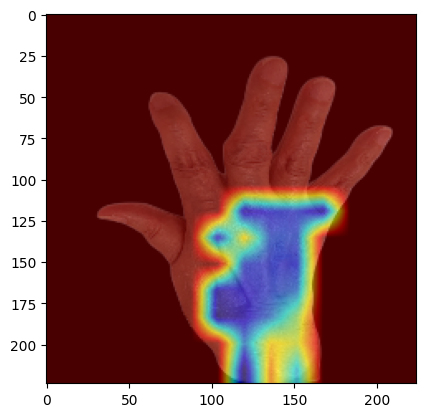

In [27]:
import matplotlib.pyplot as plt

# 画像の読み込みとCAMの適用
rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

grayscale_cam = cam(input_tensor=input_tensor, targets=targets, eigen_smooth=args.eigen_smooth, aug_smooth=args.aug_smooth)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)

# 画像の表示
plt.imshow(cam_image)
plt.show()
